[Launch this notebook](https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb) in Google Colab:

<a href="https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" alt="https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb"></a>


Welcome to the introductory tutorial for the following two papers:

* **Multilingual Spoken Words Corpus,** NeurIPS Datasets & Benchmarks Track 2021

[`[paper]`](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/fe131d7f5a6b38b23cc967316c13dae2-Paper-round2.pdf)  [`[code]`](https://github.com/harvard-edge/multilingual_kws/) [`[dataset download]`](https://mlcommons.org/en/multilingual-spoken-words)

> *Abstract:* The **Multilingual Spoken Words Corpus (MSWC)** is a large and growing audio dataset of spoken words in 50 languages collectively spoken by over 5 billion people, for academic research and commercial applications in keyword spotting and spoken term search, licensed under CC-BY 4.0. The dataset contains more than 340,000 keywords, totaling 23.4 million 1-second spoken examples (over 6,000 hours). The dataset has many use cases, ranging from voice-enabled consumer devices to call center automation. For many under-resourced languages, this dataset is the first publicly-available keyword spotting corpus. We generate this dataset by applying forced alignment on crowd-sourced sentence-level audio to produce per-word timing estimates for extraction. All alignments are included in the dataset.


* **Few-Shot Keyword Spotting in Any Language,** Interspeech 2021

[`[paper]`](https://isca-speech.org/archive/pdfs/interspeech_2021/mazumder21_interspeech.pdf) [`[code]`](https://github.com/harvard-edge/multilingual_kws/)

> *Abstract:* We introduce a few-shot transfer learning method for keyword spotting in any language. Leveraging open speech corpora in nine languages, we automate the extraction of a large multilingual keyword bank and use it to train an embedding model. With just five training examples, we fine-tune the embedding model for keyword spotting and achieve an average F1 score of 0.75 on keyword classification for 180 new keywords unseen by the embedding model in these nine languages. This embedding model also generalizes to new languages. We achieve an average F1 score of 0.65 on 5-shot models for 260 keywords sampled across 13 new languages unseen by the embedding model. We investigate streaming accuracy for our 5-shot models in two contexts: keyword spotting and keyword search. Across 440 keywords in 22 languages, we achieve an average streaming keyword spotting accuracy of 87.4% with a false acceptance rate of 4.3%, and observe promising initial results on keyword search.

In this tutorial we will cover how the MSWC dataset is organized and how to train a few-shot keyword-spotting model with the dataset.

This notebook is designed to be run [in Google Colab](https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb), but if you want to run it locally, just change the Colab filesystem paths (e.g., `/content/subdirectory`) to point to locations on your local filesystem.


In [ ]:
%%writefile bench.py
from time import time

import tensorflow as tf
import typer
from tensorflow.lite.experimental.microfrontend.python.ops import (
    audio_microfrontend_op as frontend_op,
)

tf.debugging.set_log_device_placement(True)


def to_micro_spectrogram(model_settings, audio):
    start = time()
    sample_rate = model_settings["sample_rate"]
    window_size_ms = (model_settings["window_size_samples"] * 1000) / sample_rate
    window_step_ms = (model_settings["window_stride_samples"] * 1000) / sample_rate
    int16_input = tf.cast(tf.multiply(audio, 32768), tf.int16)
    micro_frontend = frontend_op.audio_microfrontend(
        int16_input,
        sample_rate=sample_rate,
        window_size=window_size_ms,
        window_step=window_step_ms,
        num_channels=model_settings["fingerprint_width"],
        out_scale=1,
        out_type=tf.float32,
    )
    output = tf.multiply(micro_frontend, (10.0 / 256.0))
    finish = time()
    print(f"to_micro_spectrogram took {(finish - start)*1000} miliseconds")
    return output


def file2spec(model_settings, filepath):
    """there's a version of this that adds bg noise in AudioDataset"""
    start_file = time()
    audio_binary = tf.io.read_file(filepath)
    finish_file = time()
    start_decode = time()
    audio, _ = tf.audio.decode_wav(
        audio_binary,
        desired_channels=1,
        desired_samples=model_settings["desired_samples"],
    )
    audio = tf.squeeze(audio, axis=-1)
    finish_decode = time()
    print(f"loading file took {(finish_file - start_file)*1000} miliseconds")
    print(f"decode took {(finish_decode - start_decode)*1000} miliseconds")
    return to_micro_spectrogram(model_settings, audio)


def main(filepath: str):
    model_settings = {
        "desired_samples": 16000,
        "window_size_samples": 480,
        "window_stride_samples": 320,
        "spectrogram_length": 49,
        "fingerprint_width": 40,
        "fingerprint_size": 1960,
        "label_count": 1,
        "sample_rate": 16000,
        "preprocess": "micro",
        "average_window_width": -1,
    }

    print(f"Filepath given: {filepath}")
    tensor_def = file2spec(model_settings, filepath)
    print(tensor_def.shape)


if __name__ == "__main__":
    typer.run(main)

Overwriting bench.py


## Step 1: Import Modules

We begin by cloning our code repository and importing several modules:

In [ ]:
!git clone https://github.com/harvard-edge/multilingual_kws/

Cloning into 'multilingual_kws'...
remote: Enumerating objects: 1224, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 1224 (delta 104), reused 90 (delta 83), pack-reused 1088
Receiving objects: 100% (1224/1224), 19.77 MiB | 26.15 MiB/s, done.
Resolving deltas: 100% (777/777), done.


In [ ]:
!pip install git+https://github.com/onnx/tensorflow-onnx
!pip install git+https://github.com/timsainb/noisereduce
!pip install umap-learn
!pip install wandb

In [ ]:
import tensorflow as tf
import numpy as np
import IPython
from pathlib import Path
import matplotlib.pyplot as plt
import os
import subprocess
import csv
from tqdm.notebook import tqdm
import umap
import pandas as pd
import sklearn.preprocessing
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.io as pio
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import (
    audio_microfrontend_op as frontend_op,
)
from tensorflow.python.platform import gfile
import numpy as np  # TODO(mmaz) tf2.4 np from tf.experimental
import os
import glob
import math
from pathlib import Path
from dataclasses import dataclass
import os
import logging
from typing import Dict, List, Optional

import glob
import numpy as np
import tensorflow as tf

import sys

# Step 2: Download the Data

Next, we download the following assets:

* Google Speech Commands (GSC) [`[paper]`](https://arxiv.org/abs/1804.03209), a reference-quality keyword spotting dataset in English. We will use the background noise samples in GSC for finetuning our model.
* The MSWC *microset:*
> This is a small portion (a "microset") of the data available for the English and Spanish languages in the Multilingual Spoken Words Corpus (MSWC), limited to 6000 clips per keyword, and constrained to only 31 keywords in English and 20 keywords in Spanish. The intent of this small subset is to aid in preliminary experimentation, inspection, and tutorials, without requiring users to download the full MSWC dataset or the full subset of MSWC in English or Spanish.
* A multilingual embedding model, which is a pretrained keyword feature extractor which can be used to perform few-shot keyword spotting (see our Interspeech21 paper for additional details). We will finetune this pretrained model.
* An unknown-keyword dataset: a precomputed bank of unknown keywords to preserve the ability for a few-shot model to distinguish between the target keyword and non-target keywords (see our Interspeech21 paper for additional details). We will also use samples from this bank to finetune our keyword spotting model.

In [ ]:
assets = [
    (
        "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
        "/content/speech_commands",
    ),
    (
        "https://storage.googleapis.com/public-datasets-mswc/mswc_microset.tar.gz",
        "/content/mswc_microset",
    ),
    (
        "https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/multilingual_context_73_0.8011.tar.gz",
        "/content/embedding_model",
    ),
    (
        "https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/unknown_files.tar.gz",
        "/content/unknown_files",
    ),
]
for asset, cache in assets:
    tf.keras.utils.get_file(origin=asset, untar=True, cache_subdir=cache)

51730843/51730843 [==============================] - 0s 0us/step


In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

We need to convert the 48KHz `.opus` files in MSWC to 16KHz `.wav` files. First let's install the `opus-tools` package:

In [ ]:
!apt-get -qq install opus-tools sox

Selecting previously unselected package libpcap0.8:amd64.
(Reading database ... 120511 files and directories currently installed.)
Preparing to unpack .../0-libpcap0.8_1.10.1-4build1_amd64.deb ...
Unpacking libpcap0.8:amd64 (1.10.1-4build1) ...
Selecting previously unselected package libopencore-amrnb0:amd64.
Preparing to unpack .../1-libopencore-amrnb0_0.1.5-1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.5-1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../2-libopencore-amrwb0_0.1.5-1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.5-1) ...
Selecting previously unselected package libsox3:amd64.
Preparing to unpack .../3-libsox3_14.4.2+git20190427-2+deb11u2build0.22.04.1_amd64.deb ...
Unpacking libsox3:amd64 (14.4.2+git20190427-2+deb11u2build0.22.04.1) ...
Selecting previously unselected package libsox-fmt-alsa:amd64.
Preparing to unpack .../4-libsox-fmt-alsa_14.4.2+git20190427-2+deb11u2build0.22.04.1_amd64.deb ...
Unpacking 

In [ ]:
!mkdir negative-examples
!mkdir negative-examples/other
!mkdir negative-examples/ours
!mkdir positive-examples
!mkdir positive-examples/other
!mkdir positive-examples/ours
!mkdir noise

In [ ]:
%%bash

bucket_name="autonomy-vision"
directory_path="audios/negative-examples"
temp_file="temp_list.txt"

# List the files in the specified directory path
gsutil ls "gs://$bucket_name/$directory_path" > "$temp_file"

# Download each of those files into the local path in parallel
cat "$temp_file" | gsutil -m cp -I /content/negative-examples/ours

# Optionally, remove the temporary file
rm "$temp_file"

In [ ]:
%%bash

bucket_name="autonomy-vision"
directory_path="audios/other-negative-examples"
temp_file="temp_list.txt"

# List the files in the specified directory path
gsutil ls "gs://$bucket_name/$directory_path" > "$temp_file"

# Download each of those files into the local path in parallel
cat "$temp_file" | gsutil -m cp -I /content/negative-examples/other

# Optionally, remove the temporary file
rm "$temp_file"

In [ ]:
%%bash

bucket_name="autonomy-vision"
directory_path="audios/noise"
temp_file="temp_list.txt"

# List the files in the specified directory path
gsutil ls "gs://$bucket_name/$directory_path" > "$temp_file"

# Download each of those files into the local path in parallel
cat "$temp_file" | gsutil -m cp -I /content/noise

# Optionally, remove the temporary file
rm "$temp_file"

In [ ]:
%%bash

bucket_name="autonomy-vision"
directory_path="audios/keyword-dataset"
temp_file="temp_list.txt"

# List the files in the specified directory path
gsutil ls "gs://$bucket_name/$directory_path" > "$temp_file"

# Download each of those files into the local path in parallel
cat "$temp_file" | gsutil -m cp -I /content/positive-examples/ours

# Optionally, remove the temporary file
rm "$temp_file"

In [ ]:
%%bash

bucket_name="autonomy-vision"
directory_path="audios/synthetic-keyword-examples"
number_of_files=1500
temp_file="temp_list.txt"

# List the files and take the first $number_of_files of them
(gsutil ls "gs://$bucket_name/$directory_path" | head -n $number_of_files) > "$temp_file"

# Download each of those files into the local path in parallel
cat "$temp_file" | gsutil -m cp -I /content/positive-examples/other

# Optionally, remove the temporary file
rm "$temp_file"

In [ ]:
positive_files = list(
    sorted(Path("/content/positive-examples/ours").glob("*.wav"))
) + list(sorted(Path("/content/positive-examples/other").glob("*.wav")))
negative_files = list(
    sorted(Path("/content/negative-examples/ours").glob("*.wav"))
) + list(sorted(Path("/content/negative-examples/other").glob("*.wav")))


def listen(filepath):
    IPython.display.display(IPython.display.Audio(filename=filepath, rate="16000"))


print("Hey Kiwibot")
listen(positive_files[0])
print("Other")
listen(negative_files[0])

Hey Kiwibot


Other


In [ ]:
"""
audio_cleaning.py

A script containing a Class for cleaning audio using a notch filter and spectral
gating (optional).

Usage:
    python audio_cleaning.py

Test:
The script loads an audio file, cleans it using a notch filter and spectral gating,
and writes the cleaned audio to a new file.
"""

# Imports
import soundfile as sf
import torch
import torchaudio
from noisereduce.torchgate import TorchGate as TG
from scipy import signal


class AudioCleaner(torch.nn.Module):
    """
    A PyTorch module for cleaning audio using a notch filter and spectral gating.

    Args:
        use_spectral_gating (bool): Whether to use spectral gating to further clean
            the audio. If True, the audio needs to have just one channel.
        notch_freq (float): The frequency of the notch filter in Hz.
        quality_factor (float): The quality factor of the notch filter.
        samp_freq (int): The sampling frequency of the audio in Hz.
        gaining_factor (float): The factor by which to multiply the audio after
    """

    def __init__(
        self,
        use_spectral_gating: bool = False,
        notch_freq: float = 325,
        quality_factor: float = 30,
        samp_freq: int = 16000,
        gaining_factor: float = 3.5,
    ):
        super().__init__()
        self.use_second_op = use_spectral_gating
        self.gaining_factor = gaining_factor

        # Compute notch filter coefficients
        b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
        self.a_coeffs = torch.tensor(a_notch, dtype=torch.float32)
        self.b_coeffs = torch.tensor(b_notch, dtype=torch.float32)

        if use_spectral_gating:
            # Create TorchGating instance
            self.tg = TG(
                sr=samp_freq,
                nonstationary=False,
                freq_mask_smooth_hz=1500,
                prop_decrease=0.93,
            )

    def to(self, device):
        """
        Override the `to` method to also move coefficients to the device.
        """
        super().to(device)  # This will move all nn.Module parameters to the device
        self.a_coeffs = self.a_coeffs.to(device)
        self.b_coeffs = self.b_coeffs.to(device)
        if self.use_second_op:
            self.tg = self.tg.to(device)
        return self

    def clean_resonance(self, audio: torch.Tensor) -> torch.Tensor:
        """
        Cleans audio using a notch filter.

        Args:
            audio (torch.Tensor): The audio to clean.

        Returns:
            torch.Tensor: The cleaned audio.
        """
        cleaned_audio = torchaudio.functional.filtfilt(
            audio, self.a_coeffs, self.b_coeffs
        )
        return cleaned_audio

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        Cleans audio using a notch filter and spectral gating.

        Args:
            audio (torch.Tensor): The audio to clean.

        Returns:
            torch.Tensor: The cleaned audio.
        """
        clean_audio = self.clean_resonance(audio)

        if self.use_second_op:
            clean_audio = self.tg(clean_audio)
            clean_audio = clean_audio * self.gaining_factor
            # Normalize to prevent clipping
            clean_audio = torch.clip(clean_audio, -1.0, 1.0)

        return clean_audio

In [ ]:
def prepare_model_settings(
    label_count,
    sample_rate,
    clip_duration_ms,
    window_size_ms,
    window_stride_ms,
    feature_bin_count,
    preprocess,
):
    """
      source: https://git.io/JkuvF
      Calculates common settings needed for all models.

    Args:
      label_count: How many classes are to be recognized.
      sample_rate: Number of audio samples per second.
      clip_duration_ms: Length of each audio clip to be analyzed.
      window_size_ms: Duration of frequency analysis window.
      window_stride_ms: How far to move in time between frequency windows.
      feature_bin_count: Number of frequency bins to use for analysis.
      preprocess: How the spectrogram is processed to produce features.

    Returns:
      Dictionary containing common settings.

    Raises:
      ValueError: If the preprocessing mode isn't recognized.
    """
    desired_samples = int(sample_rate * clip_duration_ms / 1000)
    window_size_samples = int(sample_rate * window_size_ms / 1000)
    window_stride_samples = int(sample_rate * window_stride_ms / 1000)
    length_minus_window = desired_samples - window_size_samples
    if length_minus_window < 0:
        spectrogram_length = 0
    else:
        spectrogram_length = 1 + int(length_minus_window / window_stride_samples)
    if preprocess == "average":
        fft_bin_count = 1 + (_next_power_of_two(window_size_samples) / 2)
        average_window_width = int(math.floor(fft_bin_count / feature_bin_count))
        fingerprint_width = int(math.ceil(fft_bin_count / average_window_width))
    elif preprocess == "mfcc":
        average_window_width = -1
        fingerprint_width = feature_bin_count
    elif preprocess == "micro":
        average_window_width = -1
        fingerprint_width = feature_bin_count
    else:
        raise ValueError(
            'Unknown preprocess mode "%s" (should be "mfcc",'
            ' "average", or "micro")' % (preprocess)
        )
    fingerprint_size = fingerprint_width * spectrogram_length
    return {
        "desired_samples": desired_samples,
        "window_size_samples": window_size_samples,
        "window_stride_samples": window_stride_samples,
        "spectrogram_length": spectrogram_length,
        "fingerprint_width": fingerprint_width,
        "fingerprint_size": fingerprint_size,
        "label_count": label_count,
        "sample_rate": sample_rate,
        "preprocess": preprocess,
        "average_window_width": average_window_width,
    }


def standard_microspeech_model_settings(label_count: int):
    return prepare_model_settings(
        label_count=label_count,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )

In [ ]:
def to_micro_spectrogram(model_settings, audio):
    sample_rate = model_settings["sample_rate"]
    window_size_ms = (model_settings["window_size_samples"] * 1000) / sample_rate
    window_step_ms = (model_settings["window_stride_samples"] * 1000) / sample_rate
    int16_input = tf.cast(tf.multiply(audio, 32768), tf.int16)
    # https://git.io/Jkuux
    micro_frontend = frontend_op.audio_microfrontend(
        int16_input,
        sample_rate=sample_rate,
        window_size=window_size_ms,
        window_step=window_step_ms,
        num_channels=model_settings["fingerprint_width"],
        out_scale=1,
        out_type=tf.float32,
    )
    output = tf.multiply(micro_frontend, (10.0 / 256.0))
    return output


def file2spec(model_settings, filepath):
    """there's a version of this that adds bg noise in AudioDataset"""
    audio_binary = tf.io.read_file(filepath)
    audio, _ = tf.audio.decode_wav(
        audio_binary,
        desired_channels=1,
        desired_samples=model_settings["desired_samples"],
    )
    audio = tf.transpose(audio)
    return to_micro_spectrogram(model_settings, audio)


def cleaned_file2spec(model_settings, filepath):
    """there's a version of this that adds bg noise in AudioDataset"""
    audio_binary = tf.io.read_file(filepath)
    noise_reductor = AudioCleaner(use_spectral_gating=True)
    audio, _ = tf.audio.decode_wav(
        audio_binary,
        desired_channels=1,
        desired_samples=model_settings["desired_samples"],
    )

    # audio = tf.squeeze(audio, axis=-1)
    audio = tf.transpose(audio)
    cleaned_audio = noise_reductor(torch.Tensor(audio.numpy()))
    return to_micro_spectrogram(
        model_settings, tf.convert_to_tensor(cleaned_audio.numpy())
    )

We can also look at the spectrograms for these three examples, using TensorFlow Lite Micro's speech preprocessing frontend.

See [this link](https://github.com/tensorflow/tflite-micro/tree/5857f676b022406ed063c9d7291a13f92907a4e6/tensorflow/lite/micro/examples/micro_speech/train#preprocessing-speech-input) for additional documentation on the frontend (and note that multiple feature preprocessors are available).

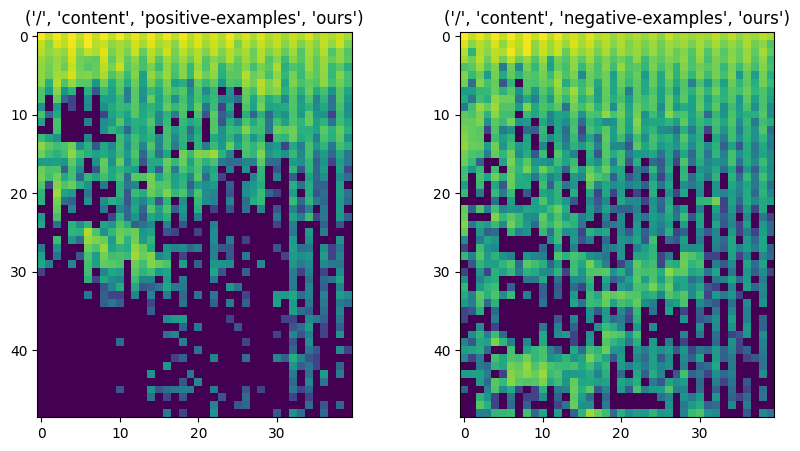

In [ ]:
settings = standard_microspeech_model_settings(label_count=1)
fig, axes = plt.subplots(ncols=2)
for sample, ax in zip([positive_files[0], negative_files[0]], axes):
    spectrogram = file2spec(settings, str(sample))  # PosixPath not supported
    ax.imshow(spectrogram.numpy())
    ax.set_title(sample.parts[:4])
fig.set_size_inches(10, 5)

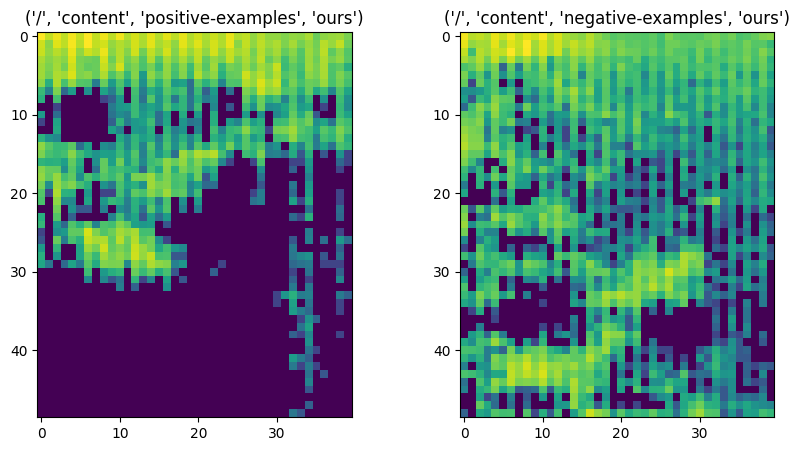

In [ ]:
settings = standard_microspeech_model_settings(label_count=1)
fig, axes = plt.subplots(ncols=2)
for sample, ax in zip([positive_files[0], negative_files[0]], axes):
    spectrogram = cleaned_file2spec(settings, str(sample))  # PosixPath not supported
    ax.imshow(spectrogram.numpy())
    ax.set_title(sample.parts[:4])
fig.set_size_inches(10, 5)

Let's also look at the properties of our converted MSWC `.wav` files. Note that they're all 16KHz and exactly 1 second long, conforming to our expected network inputs below.

In [ ]:
print(subprocess.check_output(["soxi", "/content/noise/noise_long.wav"]).decode("utf8"))


Input File     : '/content/noise/noise_long.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:02:00.00 = 1920000 samples ~ 9000 CDDA sectors
File Size      : 3.84M
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM




# Step 3: Train a Keyword Spotting Model
Now let's create an embedding model from the pretrained classification model. To do so, we simply remove the last layer from the classifier.

**Note:** Tensorflow will print a large number of warnings upon loading the model, which can be ignored.

In [ ]:
base_model = tf.keras.models.load_model(
    "./embedding_model/multilingual_context_73_0.8011"
)
embedding = tf.keras.models.Model(
    name="embedding_model",
    inputs=base_model.inputs,
    outputs=base_model.get_layer(name="dense_2").output,
)
embedding.trainable = False

Let us look at an embedding representation for one of our samples above:

Filepath: /content/positive-examples/ours/10_wake-up-word_13-07-2023_20-40-04.wav
Spectrogram shape (49, 40)
1/1 [==============================] - 10s 10s/step
Feature vector shape: (1, 1024)


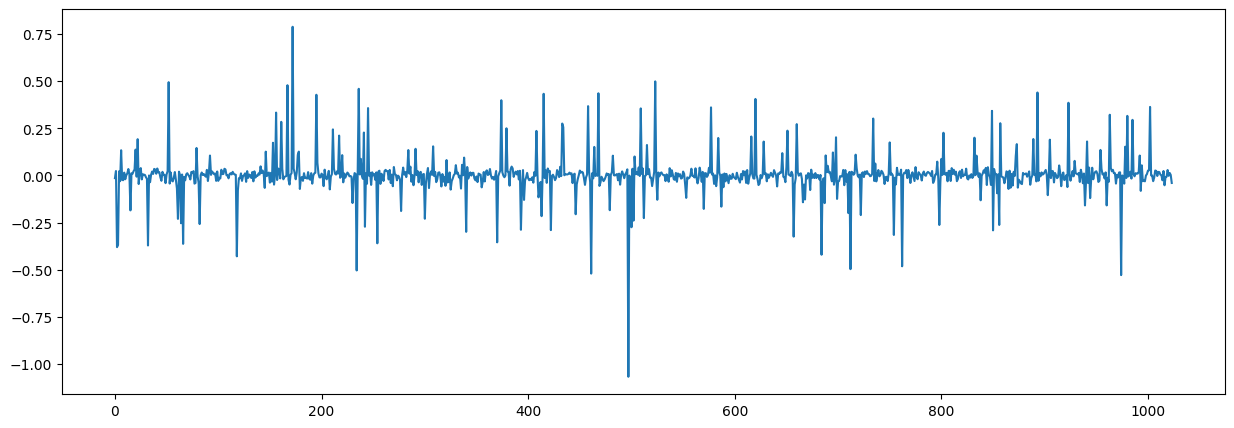

In [ ]:
sample_fpath = str(positive_files[0])
print("Filepath:", sample_fpath)
spectrogram = cleaned_file2spec(settings, sample_fpath)
print("Spectrogram shape", spectrogram.shape)
# retrieve embedding vector representation (reshape into 1x49x40x1)
feature_vec = embedding.predict(spectrogram[tf.newaxis, :, :, tf.newaxis])
print("Feature vector shape:", feature_vec.shape)
plt.plot(feature_vec[0])
plt.gcf().set_size_inches(15, 5)

# Optional Embedding Visualization
We can look at a 2D projection of the embedding representation for all of the keyword samples in English to see if keywords appear to cluster together (and are separated from other keywords) by using the [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) dimensionality reduction algorithm. This will project each 1024-D feature vector into a 2D space, allowing us to visualize each keyword cluster.

22/22 [==============================] - 1s 33ms/step


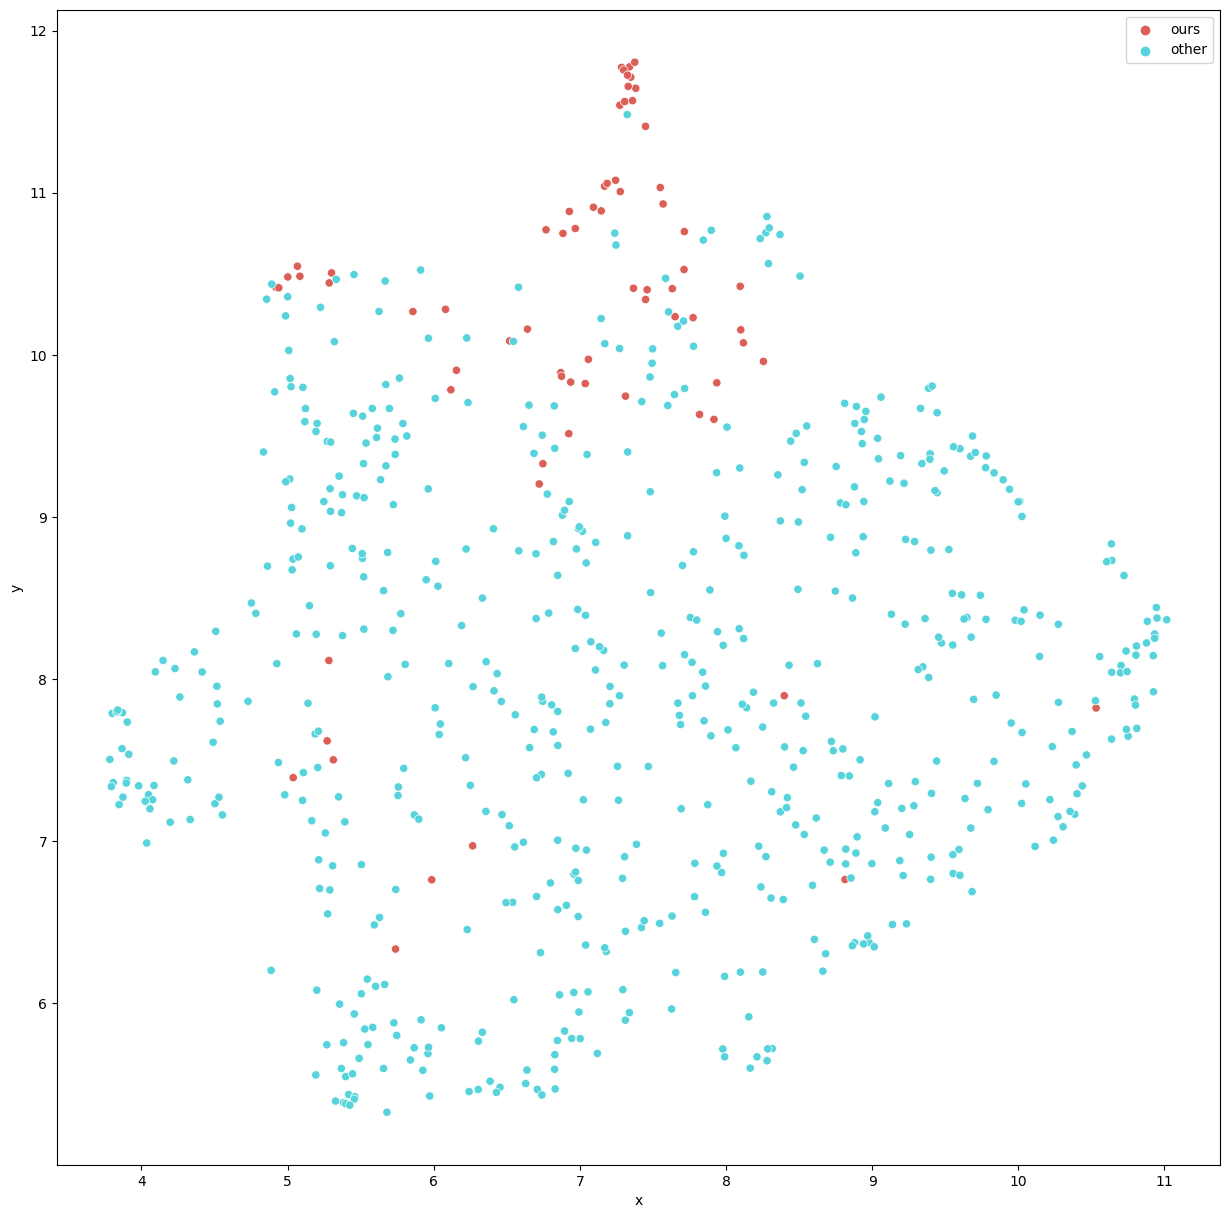

In [ ]:
reducer = umap.UMAP()
wavs = positive_files
wavs_str = [str(wav) for wav in wavs]
labels = [w.parts[-2] for w in wavs]
spectrograms = np.array([file2spec(settings, str(w)) for w in wavs])
embeddings = embedding.predict(spectrograms[:, :, :, tf.newaxis])
scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
projection = reducer.fit_transform(scaled_embeddings)
df = pd.DataFrame(data=dict(x=projection[:, 0], y=projection[:, 1], keyword=labels))
kws = set(df.keyword.tolist())
fig = px.scatter(df, x="x", y="y", color="keyword")
fig.update_layout(width=800, height=800)
fig.show()

In [ ]:
reducer = umap.UMAP()
wavs = negative_files
wavs_str = [str(wav) for wav in wavs]
labels = [w.parts[-2] for w in wavs]
spectrograms = np.array([file2spec(settings, str(w)) for w in wavs])
embeddings = embedding.predict(spectrograms[:, :, :, tf.newaxis])
scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
projection = reducer.fit_transform(scaled_embeddings)
df = pd.DataFrame(data=dict(x=projection[:, 0], y=projection[:, 1], keyword=labels))
kws = set(df.keyword.tolist())
fig = px.scatter(df, x="x", y="y", color="keyword")
fig.update_layout(width=800, height=800)
fig.show()

165/165 [==============================] - 2s 14ms/step


In [ ]:
reducer = umap.UMAP()
wavs = positive_files + negative_files
wavs_str = [str(wav) for wav in wavs]
labels = [w.parts[-3] + "/" + w.parts[-2] for w in wavs]
spectrograms = np.array([file2spec(settings, str(w)) for w in wavs])
embeddings = embedding.predict(spectrograms[:, :, :, tf.newaxis])
scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
projection = reducer.fit_transform(scaled_embeddings)
df = pd.DataFrame(
    data=dict(x=projection[:, 0], y=projection[:, 1], keyword=labels, file=wavs_str)
)
kws = set(df.keyword.tolist())
fig = px.scatter(df, x="x", y="y", color="keyword")
fig.update_layout(width=800, height=800)
fig.show()

214/214 [==============================] - 4s 13ms/step


In [ ]:
# wavs_str = [str(wav) for wav in wavs]
# scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
# projection = TSNE(n_components=3, learning_rate='auto',init='random').fit_transform(scaled_embeddings)
df = pd.DataFrame(
    data=dict(
        x=projection[:, 0],
        y=projection[:, 1],
        z=projection[:, 2],
        keyword=labels,
        file=wavs_str,
    )
)
kws = set(df.keyword.tolist())
fig = px.scatter_3d(df, x="x", y="y", z="z", hover_data=["file"], color="keyword")
fig.update_traces(marker_size=2)
fig.show()

In [ ]:
# Save the figure as an HTML file
pio.write_html(fig, file="embeddings.html", auto_open=True)

In [ ]:
from sklearn.model_selection import train_test_split

negative_files_str = [str(path) for path in negative_files]
# Split the list of files into train, validation, and test sets
train_negatives, test_negatives = train_test_split(
    negative_files_str, test_size=0.1, random_state=42
)

# Print the number of files in each set
print(f"Number of train files: {len(train_negatives)}")
print(f"Number of test files: {len(test_negatives)}")

Number of train files: 4746
Number of test files: 528


In [ ]:
from sklearn.model_selection import train_test_split

positive_files_str = [str(path) for path in positive_files]
# Split the list of files into train, validation, and test sets
train_samples, test_samples = train_test_split(
    positive_files_str, test_size=0.2, random_state=42
)
train_samples, valid_samples = train_test_split(
    train_samples, test_size=0.3, random_state=42
)

# Print the number of files in each set
print(f"Number of train files: {len(train_samples)}")
print(f"Number of validation files: {len(valid_samples)}")
print(f"Number of test files: {len(test_samples)}")

Number of train files: 879
Number of validation files: 377
Number of test files: 314


Let's choose 5 training samples from the training split and listen to them:

In [ ]:
rng = np.random.RandomState(0)
five_samples = rng.choice(train_samples, 5, replace=False).tolist()
print(five_samples)
for s in five_samples:
    listen(s)

['/content/positive-examples/ours/45_wake-up-word_25-07-2023_20-30-17.wav', '/content/positive-examples/other/1584-es_speaker_8.wav', '/content/positive-examples/other/2617-es_speaker_9.wav', '/content/positive-examples/other/1939-fr_speaker_0.wav', '/content/positive-examples/other/2666-it_speaker_9.wav']


In [ ]:
SILENCE_LABEL = "_unknown_"
SILENCE_INDEX = 0
UNKNOWN_WORD_LABEL = "_unknown_"
UNKNOWN_WORD_INDEX = 0


def _next_power_of_two(x):
    """Calculates the smallest enclosing power of two for an input.
      source: https://git.io/JkuvF

    Args:
      x: Positive float or integer number.

    Returns:
      Next largest power of two integer.
    """
    return 1 if x == 0 else 2 ** (int(x) - 1).bit_length()


def add_background(foreground_audio, background_audio, background_volume):
    foreground_rms = tf.sqrt(tf.reduce_mean(tf.square(foreground_audio)))
    background_rms = tf.sqrt(tf.reduce_mean(tf.square(background_audio)))

    snr_scaling = tf.cond(
        tf.greater(background_rms, tf.constant(0.0)),
        lambda: tf.divide(foreground_rms, background_rms),
        lambda: tf.constant(0.0),
    )

    # background_data_scaled has the same average signal power (really, rms) as the foreground_audio
    background_data_scaled = tf.multiply(background_audio, snr_scaling)

    # reduce the scaled background volume to the desired volume
    bg_mul = tf.multiply(background_data_scaled, background_volume)
    bg_add = tf.add(bg_mul, foreground_audio)
    return tf.clip_by_value(bg_add, -1.0, 1.0)


@dataclass(frozen=True)
class SpecAugParams:
    percentage: float = 80.0
    # how many augmentations to include, inclusive
    frequency_n_range: int = 2
    # how large each mask should be (pixels)
    frequency_max_px: int = 2
    # how many augmentations to include, inclusive
    time_n_range: int = 2
    # how large each mask should be (pixels)
    time_max_px: int = 2


class AudioDataset:
    def __init__(
        self,
        model_settings,
        commands,
        background_data_dir,
        unknown_files,
        time_shift_ms=100,
        background_frequency=0.8,
        background_volume_range=0.1,
        silence_percentage=10.0,
        unknown_percentage=10.0,
        spec_aug_params=SpecAugParams(),
        seed=None,
    ) -> None:
        self.get_background_data(background_data_dir)
        self.model_settings = model_settings
        self.max_time_shift_samples = self.timeshift_samples(
            time_shift_ms=time_shift_ms
        )
        self.background_frequency = background_frequency  # freq. between 0-1
        self.background_volume_range = background_volume_range

        # below list prepending is order-sensitive (unknown, then silence)
        # so that with both, labels are always ordered:
        # [silence, unknown, word1, word2,...]
        self.unknown_percentage = unknown_percentage
        self.unknown_files = unknown_files
        if len(self.unknown_files) > 0 and self.unknown_percentage > 0:
            commands = [UNKNOWN_WORD_LABEL] + commands
        self.silence_percentage = silence_percentage  # pct between 0-100
        # if self.silence_percentage > 0:
        #     commands = [SILENCE_LABEL] + commands
        self.commands = tf.convert_to_tensor(commands)

        self.spec_aug_params = spec_aug_params

        if seed:
            self.gen = tf.random.Generator.from_seed(seed)
        else:
            self.gen = tf.random.Generator.from_non_deterministic_state()

    def timeshift_samples(self, time_shift_ms=100):
        sample_rate = self.model_settings["sample_rate"]
        return int((time_shift_ms * sample_rate) / 1000)

    #####
    ## augmentations
    #####

    # todo: import more augmentations from https://github.com/mozilla/DeepSpeech/blob/3762a9b5884d4646c223198f89400265d1d50fae/training/deepspeech_training/util/augmentations.py
    # https://github.com/mozilla/DeepSpeech/blob/master/doc/TRAINING.rst#sample-domain-augmentations
    # overlay (bgaudio), reverb, pitch, frequency/time masking

    def random_background_sample(self, background_volume=1.0):
        desired_samples = self.model_settings["desired_samples"]
        background_index = tf.random.uniform(
            [], 0, self.background_sizes.shape[0], tf.dtypes.int32
        )
        wav_length = self.background_sizes[background_index]
        background_samples = self.background_data[background_index, 0:wav_length]

        background_offset = self.gen.uniform(
            [],
            0,
            wav_length - desired_samples,
            dtype=tf.int32,
        )
        background_clipped = background_samples[
            background_offset : (background_offset + desired_samples)
        ]
        background_clipped = tf.multiply(background_clipped, background_volume)
        # TODO(mmaz) why is this reshape necessary?
        return tf.reshape(background_clipped, (desired_samples,))

    def random_timeshift(self, audio):
        desired_samples = self.model_settings["desired_samples"]
        time_shift_amount = self.gen.uniform(
            [],
            -self.max_time_shift_samples,
            self.max_time_shift_samples,
            dtype=tf.int32,
        )
        if time_shift_amount > 0:
            # pad beginning of wav
            # padding = tf.constant(([[time_shift_amount, 0]]))
            padding = tf.expand_dims(
                tf.stack([time_shift_amount, tf.constant(0)]), axis=0
            )
            offset = 0
        else:
            # padding = tf.constant([[0, -time_shift_amount]])
            padding = tf.expand_dims(
                tf.stack([tf.constant(0), -time_shift_amount]), axis=0
            )
            offset = -time_shift_amount
        pad = tf.pad(audio, padding, mode="CONSTANT")
        sliced = tf.slice(pad, [offset], [desired_samples])
        return sliced

    def get_unknown(self):
        unknown_index = self.gen.uniform([], 0, len(self.unknown_files), dtype=tf.int32)
        file_path = tf.gather(self.unknown_files, unknown_index)
        audio_binary = tf.io.read_file(file_path)
        waveform = self.decode_audio(audio_binary)
        return waveform

    def augment(self, audio, label):
        # see discussion on random:
        # https://github.com/tensorflow/tensorflow/issues/35682#issuecomment-574092770

        audio = (
            self.random_timeshift(audio) if self.max_time_shift_samples > 0 else audio
        )
        if self.gen.uniform([], 0, 1) < (self.silence_percentage / 100):
            background_volume = self.gen.uniform([], 0, 1)
            label = SILENCE_LABEL
            audio = self.random_background_sample(background_volume)
        elif len(self.unknown_files) > 0 and self.gen.uniform([], 0, 1) < (
            self.unknown_percentage / 100
        ):
            audio = self.get_unknown()
            audio = (
                self.random_timeshift(audio)
                if self.max_time_shift_samples > 0
                else audio
            )
            # TODO(mmaz): add in background noise?
            label = UNKNOWN_WORD_LABEL
        # mix in background?
        elif self.gen.uniform([], 0, 1) < self.background_frequency:
            background_volume = self.gen.uniform([], 0, self.background_volume_range)
            background_audio = self.random_background_sample()
            audio = add_background(audio, background_audio, background_volume)
        return audio, label

    def spec_augment(self, spectrogram):
        # https://git.io/JLvGB
        # https://arxiv.org/pdf/1904.08779.pdf

        s = tf.shape(spectrogram)
        # e.g., 49x40
        # cannot unpack in one line (OperatorNotAllowedInGraphError:
        #   iterating over `tf.Tensor` is not allowed in Graph execution)
        time_max = s[0]
        freq_max = s[1]

        freq_n = self.gen.uniform(
            [], 0, self.spec_aug_params.frequency_n_range + 1, dtype=tf.int32
        )
        time_n = self.gen.uniform(
            [], 0, self.spec_aug_params.time_n_range + 1, dtype=tf.int32
        )

        @tf.function
        def freq_body(ix, spectrogram_aug):
            size = self.gen.uniform(
                [], 1, self.spec_aug_params.frequency_max_px + 1, dtype=tf.int32
            )
            start = self.gen.uniform([], 0, freq_max - size, dtype=tf.int32)
            mask = tf.concat(
                [
                    tf.ones([time_max, start], dtype=tf.float32),
                    tf.zeros([time_max, size], dtype=tf.float32),
                    tf.ones([time_max, freq_max - start - size], dtype=tf.float32),
                ],
                axis=1,
            )
            return ix + 1, tf.multiply(spectrogram_aug, mask)

        spectrogram = tf.while_loop(
            lambda ix, augmented: ix < freq_n, freq_body, (0, spectrogram)
        )[1]

        @tf.function
        def time_body(ix, spectrogram_aug):
            size = self.gen.uniform(
                [], 1, self.spec_aug_params.time_max_px + 1, dtype=tf.int32
            )
            start = self.gen.uniform([], 0, time_max - size, dtype=tf.int32)
            mask = tf.concat(
                [
                    tf.ones([start, freq_max], dtype=tf.float32),
                    tf.zeros([size, freq_max], dtype=tf.float32),
                    tf.ones([time_max - start - size, freq_max], dtype=tf.float32),
                ],
                axis=0,
            )
            return ix + 1, tf.multiply(spectrogram_aug, mask)

        spectrogram = tf.while_loop(
            lambda ix, augmented: ix < time_n, time_body, (0, spectrogram)
        )[1]

        return spectrogram

    def map_spec_aug(self, spectrogram, label_id):
        if self.gen.uniform([], 0, 1) < (self.spec_aug_params.percentage / 100):
            spectrogram = self.spec_augment(spectrogram)
        return spectrogram, label_id

    #####
    ## -----end augmentations
    #####

    def get_background_data(self, background_dir):
        # TODO(mmaz): could not figure out how to use ragged tensors for this
        # so instead hacked together a single padded array :(
        background_data = []
        background_sizes = []
        for wav_path in gfile.Glob(os.path.join(background_dir, "*.wav")):
            wav_binary = tf.io.read_file(wav_path)
            audio, _ = tf.audio.decode_wav(wav_binary, desired_channels=1)
            background_sizes.append(audio.shape[0])
            background_data.append(tf.squeeze(audio, axis=-1))
        # build padded array
        bgdata = np.zeros(
            (len(background_sizes), max(background_sizes)), dtype=np.float32
        )
        for i in range(bgdata.shape[0]):
            wav = background_data[i].numpy()
            length = wav.shape[0]
            bgdata[i, 0:length] = wav
        self.background_data = tf.convert_to_tensor(bgdata)
        self.background_sizes = tf.convert_to_tensor(background_sizes)

    def decode_audio(self, audio_binary):
        desired_samples = self.model_settings["desired_samples"]
        audio, _ = tf.audio.decode_wav(
            audio_binary, desired_channels=1, desired_samples=desired_samples
        )
        return tf.squeeze(audio, axis=-1)

    def get_label(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2]

    def get_waveform_and_label(self, file_path):
        label = self.get_label(file_path)
        audio_binary = tf.io.read_file(file_path)
        waveform = self.decode_audio(audio_binary)
        return waveform, label

    def get_single_target_waveforms(self, file_path):
        label = self.commands[-1]
        audio_binary = tf.io.read_file(file_path)
        waveform = self.decode_audio(audio_binary)
        return waveform, label

    def get_spectrogram_and_label_id(self, audio, label):
        micro_spec = to_micro_spectrogram(self.model_settings, audio)
        lc = label == self.commands
        label_id = tf.argmax(lc)
        return micro_spec, label_id

    def get_label_id_from_filename(self, filepath):
        # only for rebalancer
        label = self.get_label(filepath)
        lc = label == self.commands
        label_id = tf.argmax(lc)
        return label_id

    def add_channel(self, spectrogram, label_id):
        """from width x height to width x height x channel"""
        return tf.expand_dims(spectrogram, -1), label_id

    def file2spec_w_bg(self, filepath):
        audio_binary = tf.io.read_file(filepath)
        waveform = self.decode_audio(audio_binary)
        waveform = self._add_bg(waveform)
        return to_micro_spectrogram(self.model_settings, waveform)

    def _add_bg(self, audio):
        background_volume = self.gen.uniform([], 0, self.background_volume_range)
        background_audio = self.random_background_sample()
        return add_background(audio, background_audio, background_volume)

    def init_single_target(self, AUTOTUNE, files, is_training):
        """assumes a single-target model, reads label from self.commands"""
        files_ds = tf.data.Dataset.from_tensor_slices(files)

        # buffer size with shuffle: https://stackoverflow.com/a/48096625
        waveform_ds = files_ds.map(
            self.get_single_target_waveforms, num_parallel_calls=AUTOTUNE
        )
        # https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
        waveform_ds = (
            waveform_ds.map(self.augment, num_parallel_calls=AUTOTUNE)
            if is_training
            else waveform_ds
        )

        spectrogram_ds = waveform_ds.map(
            self.get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE
        )
        spectrogram_ds = (
            spectrogram_ds.map(self.map_spec_aug, num_parallel_calls=AUTOTUNE)
            if is_training
            else spectrogram_ds
        )

        return spectrogram_ds.map(self.add_channel, num_parallel_calls=AUTOTUNE)

    def init_from_parent_dir(self, AUTOTUNE, files, is_training):
        """uses the parent dir as the label name"""
        files_ds = tf.data.Dataset.from_tensor_slices(files)
        # TODO(mmaz) should we rebalance here?
        # if rebalance:
        # we havent generated any unknowns or silence here
        # so we should probably just rebalance naively
        # 1/len(commands without silence/unknown)
        # non_word_pct = self.silence_percentage, self.unknown_percentage
        # word_pct = (1-non_word_pct) / (len(self.commands))
        # target_dist = [non_word_pct] + [ for c in self.commands]
        # resampler = tf.data.experimental.rejection_resample(
        #     self.get_label_id_from_filename, target_dist=target_dist
        # )
        # train_ds = files_ds.apply(resampler)

        # buffer size with shuffle: https://stackoverflow.com/a/48096625
        waveform_ds = files_ds.map(
            self.get_waveform_and_label, num_parallel_calls=AUTOTUNE
        )
        # https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
        waveform_ds = (
            waveform_ds.map(self.augment, num_parallel_calls=AUTOTUNE)
            if is_training
            else waveform_ds
        )
        spectrogram_ds = waveform_ds.map(
            self.get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE
        )
        spectrogram_ds = (
            spectrogram_ds.map(self.map_spec_aug, num_parallel_calls=AUTOTUNE)
            if is_training
            else spectrogram_ds
        )

        return spectrogram_ds.map(self.add_channel, num_parallel_calls=AUTOTUNE)

    def _random_silence(self):
        background_volume = self.gen.uniform([], 0, 1)
        label = SILENCE_LABEL
        audio = self.random_background_sample(background_volume)
        return audio, label

    def _random_unknown(self):
        audio = self.get_unknown()
        label = UNKNOWN_WORD_LABEL
        return audio, label

    def _random_silence_unknown(self, n_files):
        n_silent = int(n_files * self.silence_percentage / 100)
        n_unknown = int(n_files * self.unknown_percentage / 100)
        silence_samples = tf.data.Dataset.range(n_silent).map(
            lambda _: self._random_silence()
        )
        unknown_samples = tf.data.Dataset.range(n_unknown).map(
            lambda _: self._random_unknown()
        )
        return silence_samples.concatenate(unknown_samples)

    def eval_with_silence_unknown(self, AUTOTUNE, files, label_from_parent_dir: bool):
        """includes silence + unknown
        Args:
          label_from_parent_dir: bool
            if True, uses the parent directory as the label name
            if False, assumes a single-target model and reads label from self.commands
        """
        files_ds = tf.data.Dataset.from_tensor_slices(files)
        if label_from_parent_dir:
            waveform_ds = files_ds.map(
                self.get_waveform_and_label, num_parallel_calls=AUTOTUNE
            )
        else:
            assert (
                self.commands.shape[0] == 3
            ), "model does not support both silence and unknown"
            waveform_ds = files_ds.map(
                self.get_single_target_waveforms, num_parallel_calls=AUTOTUNE
            )

        waveform_ds = waveform_ds.concatenate(self._random_silence_unknown(len(files)))
        spectrogram_ds = waveform_ds.map(
            self.get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE
        )
        return spectrogram_ds.map(self.add_channel, num_parallel_calls=AUTOTUNE)


def test_timeshift():
    length = 20
    a = tf.constant(range(length)) + 1
    print(a)
    ms = 4
    amt = np.random.randint(-ms, ms)
    print("amt", amt)
    if amt > 0:
        padding = tf.constant([[amt, 0]])
        offset = 0
    else:
        padding = tf.constant([[0, -amt]])
        offset = -amt

    pad = tf.pad(a, padding, mode="CONSTANT")
    print(pad)
    sliced = tf.slice(pad, [offset], [length])
    print(sliced)

In [ ]:
def transfer_learn(
    target,
    train_files,
    val_files,
    unknown_files,
    num_epochs,
    num_batches,
    batch_size,
    primary_lr,
    backprop_into_embedding,
    embedding_lr,
    model_settings: Dict,
    base_model_path: os.PathLike,
    base_model_output: str,
    UNKNOWN_PERCENTAGE: float = 50.0,
    bg_datadir: os.PathLike = "/home/mark/tinyspeech_harvard/speech_commands/_background_noise_/",
    csvlog_dest: Optional[os.PathLike] = None,
    verbose=1,
):
    """this only words for single-target models: see audio_dataset and CATEGORIES"""

    tf.get_logger().setLevel(logging.ERROR)
    base_model = tf.keras.models.load_model(base_model_path)
    tf.get_logger().setLevel(logging.INFO)
    xfer = tf.keras.models.Model(
        name="TransferLearnedModel",
        inputs=base_model.inputs,
        outputs=base_model.get_layer(name=base_model_output).output,
    )
    xfer.trainable = False

    # dont use softmax unless losses from_logits=False
    CATEGORIES = 2  # silence + unknown + target_keyword
    tf.get_logger().info("NUmber of categories 2")
    xfer = tf.keras.models.Sequential(
        [
            xfer,
            tf.keras.layers.Dense(units=18, activation="tanh"),
            tf.keras.layers.Dense(units=CATEGORIES, activation="softmax"),
        ]
    )

    xfer.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=primary_lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )
    print("hola")
    # TODO(mmaz): use keras class weights?
    audio_dataset = AudioDataset(
        model_settings=model_settings,
        commands=[target],
        background_data_dir=bg_datadir,
        unknown_files=unknown_files,
        unknown_percentage=UNKNOWN_PERCENTAGE,
        spec_aug_params=SpecAugParams(percentage=80),
    )

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    init_train_ds = audio_dataset.init_single_target(
        AUTOTUNE, train_files, is_training=True
    )
    init_val_ds = audio_dataset.init_single_target(
        AUTOTUNE, val_files, is_training=False
    )
    train_ds = init_train_ds.shuffle(buffer_size=1000).repeat().batch(batch_size)
    val_ds = init_val_ds.batch(batch_size)

    if csvlog_dest is not None:
        callbacks = [tf.keras.callbacks.CSVLogger(csvlog_dest, append=False)]
    else:
        callbacks = []
    print("epochs: ", num_epochs)
    history = xfer.fit(
        train_ds,
        validation_data=val_ds,
        steps_per_epoch=batch_size * num_batches,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose,
    )
    if backprop_into_embedding:
        # https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights
        # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
        for layer in xfer.layers[-20:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

        xfer.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=embedding_lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"],
        )
        print("IM here")
        history = xfer.fit(
            train_ds,
            validation_data=val_ds,
            steps_per_epoch=batch_size * num_batches,
            epochs=num_epochs,
            callbacks=callbacks,
        )

    va = history.history["val_accuracy"][-1]
    name = f"xfer_epochs_{num_epochs}_bs_{batch_size}_nbs_{num_batches}_val_acc_{va:0.2f}_target_{target}"
    details = dict(
        num_epochs=num_epochs,
        batch_size=batch_size,
        num_batches=num_batches,
        val_accuracy=va,
        target=target,
    )
    return name, xfer, details


def random_sample_transfer_models(
    NUM_MODELS,
    N_SHOTS,
    VAL_UTTERANCES,
    oov_words,
    dest_dir,
    unknown_files,
    EPOCHS,
    data_dir,
    model_settings,
    base_model_path: os.PathLike,
    base_model_output="dense_2",
    UNKNOWN_PERCENTAGE=50.0,
    NUM_BATCHES=1,
    bg_datadir="/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/",
):
    assert os.path.isdir(dest_dir), f"dest dir {dest_dir} not found"
    models = np.random.choice(oov_words, NUM_MODELS, replace=False)

    for target in models:
        wavs = glob.glob(data_dir + target + "/*.wav")
        selected = np.random.choice(wavs, N_SHOTS + VAL_UTTERANCES, replace=False)

        train_files = selected[:N_SHOTS]
        np.random.shuffle(train_files)
        val_files = selected[N_SHOTS:]

        print(len(train_files), "shot:", target)

        utterances_fn = target + "_utterances.txt"
        utterances = dest_dir + utterances_fn
        print("saving", utterances)
        with open(utterances, "w") as fh:
            fh.write("\n".join(train_files))

        transfer_learn(
            dest_dir=dest_dir,
            target=target,
            train_files=train_files,
            val_files=val_files,
            unknown_files=unknown_files,
            EPOCHS=EPOCHS,
            model_settings=model_settings,
            base_model_path=base_model_path,
            base_model_output=base_model_output,
            UNKNOWN_PERCENTAGE=UNKNOWN_PERCENTAGE,
            NUM_BATCHES=NUM_BATCHES,
            bg_datadir=bg_datadir,
        )


def evaluate_fast_multiclass(
    words_to_evaluate: List[str],
    target_id: int,
    data_dir: os.PathLike,
    utterances_per_word: int,
    model: tf.keras.Model,
    model_settings: Dict,
):
    correct_confidences = []
    incorrect_confidences = []

    specs = []
    for word in words_to_evaluate:
        wavs = glob.glob(data_dir + word + "/*.wav")
        if len(wavs) > utterances_per_word:
            fs = np.random.choice(wavs, utterances_per_word, replace=False)
        else:
            print("using all wavs for ", word)
            fs = wavs
        specs.extend([input_data.file2spec(model_settings, f) for f in fs])
    specs = np.array(specs)
    preds = model.predict(np.expand_dims(specs, -1))

    # softmaxes = np.max(preds,axis=1)
    # unknown_other_words_confidences.extend(softmaxes.tolist())
    cols = np.argmax(preds, axis=1)
    # figure out how to fancy-index this later
    for row, col in enumerate(cols):
        confidence = preds[row][col]
        if col == target_id:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)
    return {
        "correct": correct_confidences,
        "incorrect": incorrect_confidences,
    }


def evaluate_fast_single_target(
    words_to_evaluate: List[str],
    target_id: int,
    data_dir: os.PathLike,
    utterances_per_word: int,
    model: tf.keras.Model,
    model_settings: Dict,
):
    specs = []
    for word in words_to_evaluate:
        wavs = glob.glob(data_dir + word + "/*.wav")
        if len(wavs) > utterances_per_word:
            fs = np.random.choice(wavs, utterances_per_word, replace=False)
        else:
            print("using all wavs for ", word)
            fs = wavs
        specs.extend([input_data.file2spec(model_settings, f) for f in fs])
    specs = np.array(specs)
    preds = model.predict(np.expand_dims(specs, -1))
    return preds[:, target_id], preds


def evaluate_files_multiclass(
    files_to_evaluate: List[os.PathLike],
    target_id: int,
    model: tf.keras.Model,
    model_settings: Dict,
):
    correct_confidences = []
    incorrect_confidences = []

    specs = [input_data.file2spec(model_settings, f) for f in files_to_evaluate]
    specs = np.array(specs)
    preds = model.predict(np.expand_dims(specs, -1))

    # softmaxes = np.max(preds,axis=1)
    # unknown_other_words_confidences.extend(softmaxes.tolist())
    cols = np.argmax(preds, axis=1)
    # figure out how to fancy-index this later
    for row, col in enumerate(cols):
        confidence = preds[row][col]
        if col == target_id:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)
    return dict(correct=correct_confidences, incorrect=incorrect_confidences)


def evaluate_files_single_target(
    files_to_evaluate: List[os.PathLike],
    target_id: int,
    model: tf.keras.Model,
    model_settings: Dict,
):
    specs = [input_data.file2spec(model_settings, f) for f in files_to_evaluate]
    specs = np.array(specs)
    preds = model.predict(np.expand_dims(specs, -1))
    return preds[:, target_id], preds


def evaluate_and_track(
    words_to_evaluate: List[str],
    target_id: int,
    data_dir: os.PathLike,
    utterances_per_word: int,
    model: tf.keras.Model,
    model_settings: Dict,
):
    # TODO(mmaz) rewrite and combine with evaluate_fast
    raise ValueError("this only works for multiclass, see other evaluation functions")

    correct_confidences = []
    incorrect_confidences = []
    track_correct = {}
    track_incorrect = {}

    for word in words_to_evaluate:
        fs = np.random.choice(
            glob.glob(data_dir + word + "/*.wav"), utterances_per_word, replace=False
        )

        track_correct[word] = []
        track_incorrect[word] = []

        specs = np.array([input_data.file2spec(model_settings, f) for f in fs])
        preds = model.predict(np.expand_dims(specs, -1))

        # softmaxes = np.max(preds,axis=1)
        # unknown_other_words_confidences.extend(softmaxes.tolist())
        cols = np.argmax(preds, axis=1)
        # figure out how to fancy-index this later
        for row, col in enumerate(cols):
            confidence = preds[row][col]
            if col == target_id:
                correct_confidences.append(confidence)
                track_correct[word].append(confidence)
            else:
                incorrect_confidences.append(confidence)
                track_incorrect[word].append(confidence)
    return {
        "correct": correct_confidences,
        "incorrect": incorrect_confidences,
        "track_correct": track_correct,
        "track_incorrect": track_incorrect,
    }

In [ ]:
background_noise = "/content/noise"
# negative_files_str = [str(file) for file in negative_files]
# print("Number of unknown files", len(negative_files_str))
model_settings = standard_microspeech_model_settings(3)
# audio_dataset = AudioDataset(
#         model_settings=model_settings,
#         commands=["hey_kiwibot"],
#         background_data_dir=background_noise,
#         unknown_files=final_unknow,
#         unknown_percentage=50,
#         spec_aug_params=SpecAugParams(percentage=80),
#     )

# AUTOTUNE = tf.data.experimental.AUTOTUNE
# init_train_ds = audio_dataset.init_single_target(
#     AUTOTUNE, train_samples, is_training=True
# )
# init_val_ds = audio_dataset.init_single_target(
#     AUTOTUNE, valid_samples, is_training=False
# )
# train_ds = init_train_ds.shuffle(buffer_size=1000).repeat().batch(64)
# val_ds = init_val_ds.batch(64)

In [ ]:
print("---Training model---")
_, model, _ = transfer_learn(
    target="hey_kiwibot",
    train_files=train_samples,
    val_files=valid_samples,
    unknown_files=train_negatives,
    num_epochs=4,
    num_batches=1,
    batch_size=64,
    primary_lr=0.001,
    backprop_into_embedding=True,
    embedding_lr=0.0005,
    model_settings=model_settings,
    base_model_path="embedding_model/multilingual_context_73_0.8011",
    base_model_output="dense_2",
    UNKNOWN_PERCENTAGE=60.0,
    bg_datadir=background_noise,
    csvlog_dest="/content/history.csv",
)
KEYWORD = "hey_kiwibot"
model.save(f"{KEYWORD}_5shot")

---Training model---


INFO:tensorflow:NUmber of categories 2


hola
epochs:  5
Epoch 1/5
64/64 [==============================] - 39s 370ms/step - loss: 0.3184 - accuracy: 0.8967 - val_loss: 0.1772 - val_accuracy: 0.9496
Epoch 2/5
64/64 [==============================] - 24s 379ms/step - loss: 0.1640 - accuracy: 0.9478 - val_loss: 0.1339 - val_accuracy: 0.9576
Epoch 3/5
64/64 [==============================] - 21s 328ms/step - loss: 0.1223 - accuracy: 0.9622 - val_loss: 0.1180 - val_accuracy: 0.9602
Epoch 4/5
64/64 [==============================] - 23s 362ms/step - loss: 0.1101 - accuracy: 0.9644 - val_loss: 0.1016 - val_accuracy: 0.9629
Epoch 5/5
64/64 [==============================] - 21s 336ms/step - loss: 0.1011 - accuracy: 0.9617 - val_loss: 0.1320 - val_accuracy: 0.9576
IM here
Epoch 1/5
64/64 [==============================] - 83s 421ms/step - loss: 0.0830 - accuracy: 0.9668 - val_loss: 0.0213 - val_accuracy: 0.9920
Epoch 2/5
64/64 [==============================] - 26s 410ms/step - loss: 0.0374 - accuracy: 0.9866 - val_loss: 0.0117 - val

INFO:tensorflow:Assets written to: hey_kiwibot_5shot/assets


In [ ]:
!gsutil cp -r /content/hey_kiwibot_8shot gs://autonomy-vision/models/tamagotchi/kwd/model

Copying file:///content/hey_kiwibot_8shot/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file:///content/hey_kiwibot_8shot/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file:///content/hey_kiwibot_8shot/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///content/hey_kiwibot_8shot/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [4 files][160.5 MiB/160.5 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///content/hey_kiwibot_8shot/variables/variables.index [Content-Type=application/octet-stream]...
- [5 files][160.6 MiB/160.6 MiB]                                                
Operation completed over 5 objects/160.6 MiB.  

In [ ]:
test_spectrograms = np.array([file2spec(model_settings, f) for f in test_samples])
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(test_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the target class?
accuracy = (
    categorical_predictions[categorical_predictions == 1].shape[0]
    / predictions.shape[0]
)
print(f"Test accuracy on testset positive: {accuracy:0.2f}")

5/5 [==============================] - 0s 13ms/step
Test accuracy on testset: 0.97


In [ ]:
test_spectrograms = np.array([file2spec(model_settings, f) for f in test_negatives])
predictions = model.predict(test_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
accuracy = (
    categorical_predictions[categorical_predictions == 0].shape[0]
    / predictions.shape[0]
)
print(f"Test accuracy on testset negative: {accuracy:0.2f}")

17/17 [==============================] - 0s 12ms/step
Test accuracy on testset negative: 0.97


In [ ]:
hey_kiwibot_files_real = list(
    sorted(Path("/content/positive-examples/ours").glob("*.wav"))
)
hey_kiwi_str_real = [str(path) for path in hey_kiwibot_files_real]

test_spectrograms = np.array([file2spec(model_settings, f) for f in hey_kiwi_str_real])
print(test_spectrograms.shape)
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(test_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the target class?
accuracy = (
    categorical_predictions[categorical_predictions == 1].shape[0]
    / predictions.shape[0]
)
print(f"Test accuracy on testset: {accuracy:0.2f}")

(71, 49, 40)
3/3 [==============================] - 1s 328ms/step
Test accuracy on testset: 0.96


In [ ]:
sample_idxs = np.random.choice(
    np.flatnonzero(categorical_predictions == 1), 5, replace=False
)
print(sample_idxs)
for i in sample_idxs:
    listen(hey_kiwi_str_real[i])

[44  6 37  8 20]


In [ ]:
# Mal seleccionados
sample_idxs = np.random.choice(
    np.flatnonzero(categorical_predictions != 1), 3, replace=False
)
print(sample_idxs)
for i in sample_idxs:
    listen(hey_kiwi_str_real[i])

[70 56 63]


In [ ]:
# Recall using google dataset
non_target_examples = []
non_target_examples.extend(Path("/content/speech_commands/one").glob("*.wav"))
non_target_examples.extend(Path("/content/speech_commands/visual").glob("*.wav"))
non_target_examples.extend(Path("/content/speech_commands/wow").glob("*.wav"))
non_target_examples.extend(Path("/content/negative-examples/ours").glob("*.wav"))

print("Number of non-target examples", len(non_target_examples))

non_target_spectrograms = np.array(
    [file2spec(model_settings, str(f)) for f in non_target_examples]
)
predictions = model.predict(non_target_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the non-target class?
accuracy = (
    categorical_predictions[categorical_predictions == 0].shape[0]
    / predictions.shape[0]
)
print(f"Estimated accuracy on non-target samples: {accuracy:0.2f}")

Number of non-target examples 7924
248/248 [==============================] - 3s 14ms/step
Estimated accuracy on non-target samples: 0.96


In [ ]:
negative_examples_real = list(
    sorted(Path("/content/negative-examples/ours").glob("*.wav"))
)
negative_examples_str_real = [str(path) for path in negative_examples_real]
print("Number of non-target examples", len(negative_examples_str_real))

non_target_spectrograms = np.array(
    [file2spec(model_settings, str(f)) for f in negative_examples_str_real]
)
predictions = model.predict(non_target_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the non-target class?
accuracy = (
    categorical_predictions[categorical_predictions == 0].shape[0]
    / predictions.shape[0]
)
print(f"Estimated accuracy on non-target samples: {accuracy:0.2f}")

Number of non-target examples 319
10/10 [==============================] - 0s 15ms/step
Estimated accuracy on non-target samples: 0.90


In [ ]:
# Mal seleccionados
sample_idxs = np.random.choice(
    np.flatnonzero(categorical_predictions != 0), 8, replace=False
)
print(sample_idxs)
for i in sample_idxs:
    listen(negative_examples_str_real[i])
    print(predictions[i])

[311 248  31  25 318 211 116  37]


[0.27640653 0.7235935 ]


[0.17535935 0.82464063]


[0.09587993 0.9041201 ]


[0.11093258 0.8890674 ]


[0.26931524 0.73068476]


[0.03905097 0.960949  ]


[0.44763047 0.5523695 ]


[0.10522497 0.89477503]


In [ ]:
from sklearn.metrics import roc_curve

roc_samples = test_samples + list(
    sorted(Path("/content/negative-examples/ours").glob("*.wav"))
)
roc_samples = [str(path) for path in roc_samples]
roc_labels = [w.split("/")[-3] for w in roc_samples]


def convert_to_binary(value):
    return 1 if value == "positive-examples" else 0


final_labels = [convert_to_binary(value) for value in roc_labels]
roc_spectrograms = np.array([file2spec(model_settings, f) for f in roc_samples])
predictions = model.predict(roc_spectrograms)
predictions = predictions[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(final_labels, predictions)

# Plot the ROC curve
# Create a DataFrame for the ROC curve
roc_df = pd.DataFrame({"False Positive Rate": fpr, "True Positive Rate": tpr})

# Plot the ROC curve using Plotly
fig = px.line(
    roc_df,
    x="False Positive Rate",
    y="True Positive Rate",
    title="Receiver Operating Characteristic",
    labels={
        "False Positive Rate": "False Positive Rate",
        "True Positive Rate": "True Positive Rate",
    },
)

# Add diagonal line
fig.add_scatter(x=[0, 1], y=[0, 1], mode="lines", line=dict(dash="dash"))

fig.show()

20/20 [==============================] - 1s 53ms/step


In [ ]:
print(thresholds)

[1.9999950e+00 9.9999499e-01 9.9999404e-01 9.9999392e-01 9.9999332e-01
 9.9999309e-01 9.9999285e-01 9.9999273e-01 9.9999261e-01 9.9999249e-01
 9.9999237e-01 9.9999225e-01 9.9999201e-01 9.9999189e-01 9.9999166e-01
 9.9999154e-01 9.9999142e-01 9.9999130e-01 9.9999118e-01 9.9999106e-01
 9.9999058e-01 9.9999046e-01 9.9999034e-01 9.9999022e-01 9.9998987e-01
 9.9998963e-01 9.9998951e-01 9.9998939e-01 9.9998903e-01 9.9998868e-01
 9.9998844e-01 9.9998832e-01 9.9998808e-01 9.9998784e-01 9.9998772e-01
 9.9998748e-01 9.9998677e-01 9.9998665e-01 9.9998653e-01 9.9998605e-01
 9.9998593e-01 9.9998558e-01 9.9998546e-01 9.9998522e-01 9.9998510e-01
 9.9998438e-01 9.9998426e-01 9.9998415e-01 9.9998403e-01 9.9998391e-01
 9.9998367e-01 9.9998295e-01 9.9998283e-01 9.9998271e-01 9.9998128e-01
 9.9998116e-01 9.9998105e-01 9.9998093e-01 9.9998033e-01 9.9998021e-01
 9.9997878e-01 9.9997866e-01 9.9997854e-01 9.9997842e-01 9.9997735e-01
 9.9997723e-01 9.9997687e-01 9.9997652e-01 9.9997461e-01 9.9997449e-01
 9.999

In [ ]:
!python -m tf2onnx.convert --saved-model /content/hey_kiwibot_4shot --output few-shot-model-final-nodamas.onnx

2023-08-09 20:45:04.794847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-08-09 20:45:08.102911: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-09 20:45:08,103 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-08-09 20:45:22,212 - INFO - Signatures found in model: [serving_default].
2023-08-09 20:45:22,212 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-08-09 20:45:22,214 - INFO - Output names: ['dense_5']
2023-08-09 20:45:27,539 - INFO - Using tensorflow=2.12.0, onnx=1.14.0, tf2onnx=1.

In [ ]:
!gsutil cp /content/few-shot-model-final-nodamas.onnx gs://autonomy-vision/models/tamagotchi/kwd/few-shot-model-final-nodamas.onnx

Copying file:///content/few-shot-model-final-nodamas.onnx [Content-Type=application/octet-stream]...
| [1 files][ 49.4 MiB/ 49.4 MiB]                                                
Operation completed over 1 objects/49.4 MiB.                                     


In [ ]:
!tar cf model.tar /content/hey_kiwibot_4shot

tar: Removing leading `/' from member names


In [ ]:
!pip install onnx
!pip install onnxruntime==1.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
"""!@package base onnx class
Base Class wrapping a onnx model.

It implements downloading the model if not present,
a generic prediction method and a warm up up method.

Code Information:
    Maintainer: Carlos Alavarez
	Mail: carlos.alvarez@kiwibot.com
	Kiwi Campus / Computer & Ai Vision Team
"""

import traceback

import numpy as np
import onnx
import onnxruntime

# from python_utils.getters import get_local_path_from_url


def infer_input_size(session):
    input_shape = session.get_inputs()[0].shape
    input_shape = tuple([*input_shape[2:], input_shape[1]])
    return input_shape


class OnnxModel(object):
    """Base model class that handles the download of the model if not
    already locally and defines some basic prediction and warm_up methods
    """

    def __init__(self, model_path: str, cuda: bool = True, label_map_key: str = None):
        """!
        Initialize the model class

        @param model_path: (str) Path to the model, should be a GCP path
        @param cuda: (bool, optional) Whether to use cuda or not. Defaults to True.
        @param label_map_key: (str, optional) Key to use to get the metadata from the model. Defaults to None.
        """
        # By default it will download it to ~/.models/saved_models/
        local_path = "/content/few-shot-model.onnx"

        onnx_model = onnx.load(local_path)
        onnx.checker.check_model(onnx_model)

        providers = (
            ["CUDAExecutionProvider", "CPUExecutionProvider"]
            if cuda
            else ["CPUExecutionProvider"]
        )
        self.session = onnxruntime.InferenceSession(local_path, providers=providers)

        self.label_map = None
        if label_map_key is not None:
            metadata_str = self.session.get_modelmeta().custom_metadata_map.get(
                label_map_key
            )
            if metadata_str is not None:
                # we need eval because it is a string
                self.label_map = eval(metadata_str)

        try:
            input_shape = infer_input_size(self.session)
        except Exception as e:
            traceback.print_exc()
            raise RuntimeError(
                f"error infering input_shape model, got {e}, setting to default shape {input_shape}"
            )

        self.input_shape = input_shape
        self.warm_up(10)

    def predict(self, frame: np.ndarray) -> np.ndarray:
        """!
        Performs basic prediction using an numpy array as input. It can be
        an image or a batch or images. This assumes the model takes only ONE input.

        @param image: (np.ndarray) Input image

        @return (np.ndarray) Returns the output prediction
        """
        is_batch = frame.ndim > 3

        # add batch dimension if case
        frame = frame[None, ...] if not is_batch else frame

        # Convert from NHWC to NCHW
        frame = frame.transpose(0, 3, 1, 2)

        # define input for onnx
        ort_inputs = {self.session.get_inputs()[0].name: frame}
        # model inference
        outputs = self.session.run(None, ort_inputs)[0]  # [0] assumes only 1 output

        outputs = outputs if is_batch else outputs[0]

        return outputs

    def warm_up(self, n_iter: int) -> None:
        """!
        Performs n_iter prediction on the model for warm up the GPU. The image of
        the input image is defined by self.input_shape

        @param n_iter: (int) Number of warm up predictions, batch_size=1
        """
        test_frame = np.random.uniform(size=self.input_shape).astype(np.float32)
        for _ in range(n_iter):
            self.predict(test_frame)

In [ ]:
import torch
import librosa
import numpy as np


def to_micro_spectrogram(model_settings, audio):
    sample_rate = model_settings["sample_rate"]
    window_size_samples = model_settings["window_size_samples"]
    window_stride_samples = model_settings["window_stride_samples"]
    num_channels = model_settings["fingerprint_width"]

    # Convert the PyTorch tensor to a NumPy array, and then to a 1D array
    # audio = audio.numpy().ravel()

    # Compute the short-time Fourier transform
    stft = librosa.stft(
        audio,
        n_fft=window_size_samples,
        hop_length=window_stride_samples,
        window="hann",
    )

    # Compute the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(
        S=np.abs(stft), sr=sample_rate, n_mels=num_channels
    )

    # Convert the spectrogram to dB scale
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Normalize the spectrogram to fit the range of int16
    spectrogram = (spectrogram + 80) / 80 * 32768

    # # Convert the spectrogram back to a PyTorch tensor
    # output = torch.from_numpy(spectrogram).float()

    # Apply the scaling
    output = spectrogram * (10.0 / 256.0)

    return output

In [ ]:
import soundfile as sf


def file2spec(model_settings, filepath):
    """there's a version of this that adds bg noise in AudioDataset"""
    waveform, sample_rate = sf.read(filepath)
    waveform = waveform[
        : model_settings["desired_samples"]
    ]  # Trim or zero pad waveform to the desired length
    if len(waveform.shape) > 1:
        waveform = waveform.mean(dim=0)  # Merge all channels
    print(waveform.shape)
    return to_micro_spectrogram(model_settings, waveform)

In [ ]:
few_shot = OnnxModel(model_path="uwu")

In [ ]:
few_shot.warm_up(3)

In [ ]:
test_spectrograms = np.array(file2spec(settings, test_samples[42]))
# test_spectrograms = np.expand_dims(test_spectrograms.T, axis=1)
test_spectrograms.shape

(16000,)


(40, 51)

In [ ]:
few_shot.predict(test_spectrograms)

array([0.00287792, 0.00378493, 0.99333715], dtype=float32)

In [ ]:
input_test = np.expand_dims(
    np.array(input_data.file2spec(settings, test_samples[42])), axis=0
)
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(input_test)
print(predictions)

1/1 [==============================] - 0s 87ms/step
[[0.00287792 0.00378494 0.99333715]]
